In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely import Point
import geopandas as gpd
import os

##### Read households and add location point

In [2]:
city_name = 'samara'
data_dir = '../data/initial_' + city_name + '/'
city_districts_file = data_dir + city_name + '_districts.geojson'

households = pd.read_csv(data_dir + 'households.txt', sep = '\t')

def generate_point_from_coords(row):
    return Point([row['longitude'], row['latitude'],])

households['location'] = households.apply(generate_point_from_coords, axis=1)

##### Read MO from city and get polygons of them

In [3]:
municipal_districts = gpd.read_file(city_districts_file)
municipal_districts = municipal_districts.rename(columns={'name': 'mo_name'})
municipal_districts = municipal_districts.sort_values(by = ['mo_name'])
municipal_districts

,osm_id,boundary,admin_level,parents,mo_name,local_name,name_en,geometry
6,-283645,administrative,9,"-287507,-72194,-1075831,-60189",Железнодорожный район,Железнодорожный район,None,"MULTIPOLYGON (((50.10364 53.17558, 50.10901 53..."
1,-285953,administrative,9,"-287507,-72194,-1075831,-60189",Кировский район,Кировский район,None,"POLYGON ((50.11259 53.31028, 50.11263 53.30873..."
0,-285954,administrative,9,"-287507,-72194,-1075831,-60189",Красноглинский район,Красноглинский район,None,"POLYGON ((49.73139 53.48063, 49.73146 53.47726..."
8,-283540,administrative,9,"-287507,-72194,-1075831,-60189",Куйбышевский район,Куйбышевский район,None,"POLYGON ((50.00880 53.15115, 50.00896 53.15005..."
5,-283781,administrative,9,"-287507,-72194,-1075831,-60189",Ленинский район,Ленинский район,None,"POLYGON ((50.05825 53.21332, 50.06155 53.21204..."
4,-284542,administrative,9,"-287507,-72194,-1075831,-60189",Октябрьский район,Октябрьский район,None,"POLYGON ((50.07591 53.23816, 50.11718 53.21049..."
2,-285136,administrative,9,"-287507,-72194,-1075831,-60189",Промышленный район,Промышленный район,None,"POLYGON ((50.12675 53.27904, 50.13339 53.27569..."
7,-283541,administrative,9,"-287507,-72194,-1075831,-60189",Самарский район,Самарский район,None,"POLYGON ((49.95306 53.17213, 49.95330 53.16858..."
3,-284582,administrative,9,"-287507,-72194,-1075831,-60189",Советский район,Советский район,None,"POLYGON ((50.18876 53.21401, 50.18901 53.21373..."


In [4]:
from tqdm import tqdm
tqdm.pandas()

def assign_mo_id(row):
    for district, geom in zip(municipal_districts['mo_name'], municipal_districts['geometry']):
        if geom.contains(row['location']):
            return str(district)
        
        
# uncomment next line if you want to create additional column with municipal district id of each household in data - this will take a while       
households['mo_name'] = households.progress_apply(assign_mo_id, axis=1)

100%|███████████████████████████████| 1158519/1158519 [03:08<00:00, 6159.21it/s]


In [5]:
households.to_csv(data_dir + 'households_with_mo_name.txt', sep = '\t')

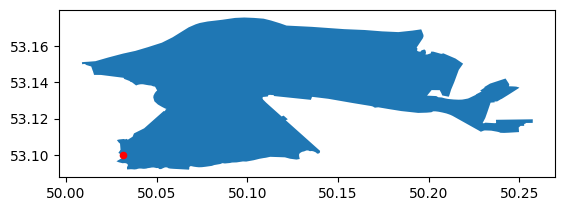

In [6]:
household = households.iloc[10]
household

district = municipal_districts.iloc[3]
mo = gpd.GeoDataFrame(columns=['mo_name', 'geometry'])
mo.loc[0] = district
mo
mo.plot()
plt.scatter(household['longitude'], household['latitude'], s=20, color='red')

In [13]:
households = pd.read_csv(data_dir+'households_with_mo_name.txt', sep='\t', index_col=0)
### SAMPLE FRACTION 
fraction = 0.25
### 
sampled_path = data_dir+'../'+ city_name+f'_{fraction*100}_sampled'
sampled_households_df = pd.DataFrame([])
for mo_id in municipal_districts['mo_name']:
    mo_df = households[households['mo_name'] == mo_id]
    mo_df = mo_df.sample(frac=fraction) # take 5 percents of all apartaments in each municipal district
    sampled_households_df = pd.concat([sampled_households_df, mo_df])
if not os.path.exists(sampled_path):
        os.makedirs(sampled_path)
sampled_households_df.to_csv(sampled_path+ '/households.txt', sep = '\t')

##### Remove people from deleted apartaments

In [14]:
sampled_households_df

,Unnamed: 0,sp_id,hh_size,latitude,longitude,location,mo_name
110850,110850,42115,5,53.179539,50.136978,POINT (50.136977703 53.179539447),Железнодорожный район
146363,146363,55384,4,53.185378,50.109856,POINT (50.109856007 53.185378263),Железнодорожный район
293103,293103,113165,4,53.198475,50.161818,POINT (50.161818084 53.198474622),Железнодорожный район
220940,220940,84655,3,53.192517,50.117946,POINT (50.117946298 53.192516814),Железнодорожный район
263325,263325,101413,3,53.196124,50.180620,POINT (50.180620248 53.196123973),Железнодорожный район
...,...,...,...,...,...,...,...
486343,486343,189641,7,53.213742,50.192025,POINT (50.192025104 53.213742015),Советский район
208248,208248,79644,1,53.191552,50.211460,POINT (50.211460317 53.191551701),Советский район
448058,448058,174462,5,53.210647,50.247216,POINT (50.247215657 53.210646563),Советский район
502291,502291,195977,3,53.215107,50.212225,POINT (50.21222465 53.2151069),Советский район


In [15]:
set_of_households = set()
for sp_id in sampled_households_df['sp_id']:
    set_of_households.add(sp_id)

print("Number of households:", len(set_of_households))
people_df = pd.read_csv(data_dir+'people.txt', sep = '\t', index_col=0) 

Number of households: 215249


In [16]:
people_sampled = people_df[people_df['sp_hh_id'].isin(set_of_households)]
people_sampled.to_csv(sampled_path+ '/people.txt', sep = '\t')

In [19]:
import os
import json

set_of_people = set(people_sampled.index.unique())

dict_school_id = json.load(open(os.path.expanduser(
    data_dir+ '/schools.json')))

dict_school_id_sampled = {}
for school in dict_school_id:
    current_list_of_students = []
    children_in_current_school = dict_school_id[school]
    for child in children_in_current_school:
        if child in set_of_people:
            current_list_of_students.append(child)
    dict_school_id_sampled[school] = current_list_of_students
    # if school == '425':
    #     print(current_list_of_students)
            
dict_school_id_sampled 
with open(sampled_path+ '/schools.json', 'w') as fp:
    json.dump(dict_school_id_sampled, fp)     
    